In [1]:
import numpy as np #  high-level mathematical functions
import pandas as pd # data manipulation and data analysis

In [15]:
# read the csv file and print the details
data = pd.read_csv('colombo_rh_2012-2018.csv')
data = data.dropna()
print('Shape of data:', data.shape)
print('Data sample:')
print(data.head())

Shape of data: (4383, 7)
Data sample:
   station_id station_name element_name  year  month  day  obs_val
0       43466      COLOMBO        RHMAX  2012      1    1     91.0
1       43466      COLOMBO        RHMAX  2012      1    2     90.0
2       43466      COLOMBO        RHMAX  2012      1    3     89.0
3       43466      COLOMBO        RHMAX  2012      1    4     89.0
4       43466      COLOMBO        RHMAX  2012      1    5     95.0


Convert the date into single column

In [16]:
# convert date columns to datetime format
data['date'] = pd.to_datetime(data[['day', 'month', 'year']], format='%d-%m-%Y')

In [17]:
# drop unwanted columns
data.drop(['day', 'month', 'year', 'station_id', 'station_name'], axis=1, inplace=True)

In [18]:
print(data)


     element_name  obs_val       date
0           RHMAX     91.0 2012-01-01
1           RHMAX     90.0 2012-01-02
2           RHMAX     89.0 2012-01-03
3           RHMAX     89.0 2012-01-04
4           RHMAX     95.0 2012-01-05
...           ...      ...        ...
4398        RHMAX     90.0 2018-12-27
4399        RHMAX     88.0 2018-12-28
4400        RHMAX     76.0 2018-12-29
4401        RHMAX     81.0 2018-12-30
4402        RHMAX     82.0 2018-12-31

[4383 rows x 3 columns]


view the dataframe details

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4402
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   element_name  4383 non-null   object        
 1   obs_val       4383 non-null   float64       
 2   date          4383 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 137.0+ KB


In [20]:
# select rows with date '2015-01-10'
print("Rows with date '2015-01-10':")
print(data[data['date'] == '2015-01-10'])


Rows with date '2015-01-10':
     element_name  obs_val       date
1125        RHMAX     72.0 2015-01-10
1490        RHMIN     60.0 2015-01-10


It seems that there are data duplication in the dataset. Specifically, for a given date, there are certain records that contain both minimum and maximum figures. Therefore, we should attempt to extract only the maximum value from these duplicates

In [21]:
# remove duplicates
data = data.groupby(['date', 'element_name'], as_index=False)['obs_val'].max()



In [27]:
# Remove duplicates
data = data.groupby(['date', 'element_name'], as_index=False)['obs_val'].max()

# If duplicates exist, keep only RHMAX
mask = data.duplicated(subset=['date'], keep=False)
data.loc[mask & (data['element_name'] == 'RHMIN'), 'element_name'] = 'RHMAX'
data.loc[mask & (data['element_name'] == 'RHMIN'), 'obs_val'] = data.loc[mask & (data['element_name'] == 'RHMAX'), 'obs_val'].values


verify the duplicates again

In [29]:
# check for duplicates in the 'name' column
duplicates = data.duplicated(subset='date', keep=False)
if duplicates.any():
    print('Duplicates found:')
    print(data[duplicates])

 duplicates not detected 

Use Augmented Dick-fuller (ADF) to check the statinary of the data

* null hypotheis H0 : the series is non-stationary
* alternative hypothesis H1 : the series is stationary

In [30]:
# perform ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(data.obs_val.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.943395
p-value: 0.000000


We will examine the seasonal component of the time series to determine whether it exhibits any seasonality. However, it is generally true that if the time series is stationary, it cannot display any seasonal component.

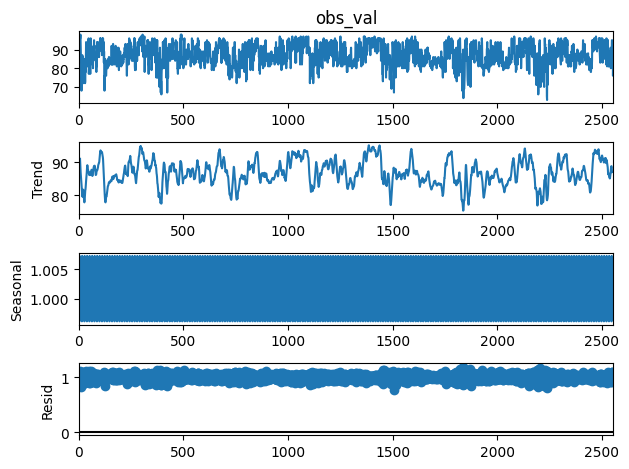

In [31]:
# perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data.obs_val, model='multiplicative', period=12)
fig = decomposition.plot()

Given that the seasonal component is fairly uniform, it appears that there is no seasonality present in the time series. This conclusion is supported by the fact that the p-value of the ADF test is less than 0.05, indicating that the time series is stationary.

As both the p-value and ADF statistic value are less than 0.05, we can reject the null hypothesis at a 0.95 significance level. Therefore, we can conclude with 95% confidence that the time series is stationary, and as a result, we do not need to differentiate the series. Thus, we can set the value of d to 0.

Next, we need to determine the order of the autoregressive (AR) and moving average (MA) terms, denoted by p and q, respectively. We can accomplish this by examining the Partial Autocorrelation (PACF) plot and Autocorrelation Function (ACF) plot. While we can use the 'autoarima' function to automatically determine the optimal values of p and q, this approach is not always accurate. Therefore, we will proceed with the traditional method of using the PACF and ACF plots.

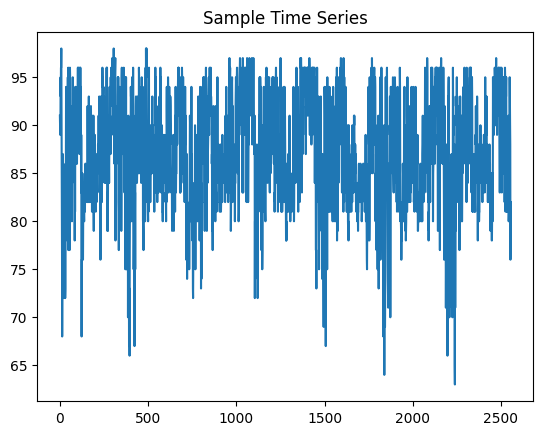

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


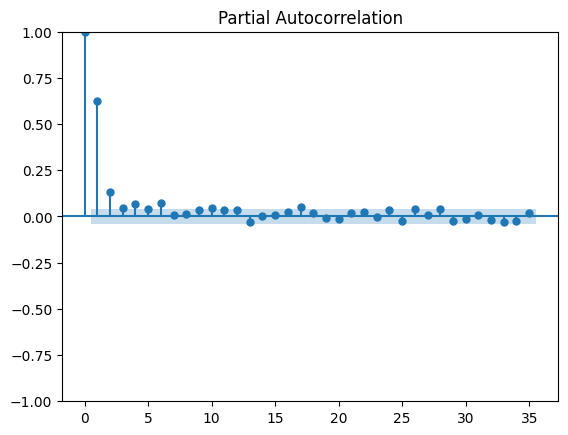

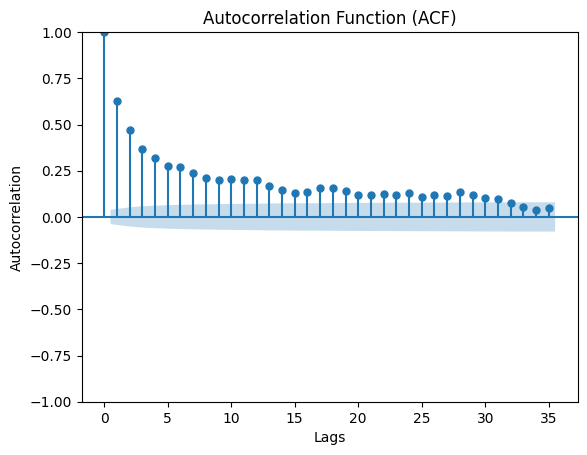

In [32]:
# plot time series, PACF, ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.plot(data.obs_val)
plt.title('Sample Time Series')
plt.show()

plot_pacf(data.obs_val)
plot_acf(data.obs_val)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


In [33]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)

According the PACF & ACF plots, the p=4,q=31. So lets fit the model & check the accuracy of the model.

In [ ]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train.obs_val, order=(4,0,31))
model_fit = model.fit()
print(model_fit.summary())

The fact that both Sigma2 and const are statistically significant (i.e., their p-values are less than 0.05) suggests that the ARIMA model is an appropriate fit for the data.

Next, we will examine whether the series has constant variance and mean.

In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

residual error is fine since 0 mean & variance 
plot with actual data

In [ ]:
# make predictions on test set
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['obs_val'].plot(legend=True)

accuracy using root mean squared error

In [37]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate the mean value of the test data
test_mean = test['obs_val'].mean()

# Calculate the root mean squared error (RMSE) between predicted and actual values
rmse = sqrt(mean_squared_error(pred, test['obs_val']))

# Print the RMSE
print('Root Mean Squared Error:', rmse)


Root Mean Squared Error: 5.888116092441722


forecast value upto 2024

<Axes: >

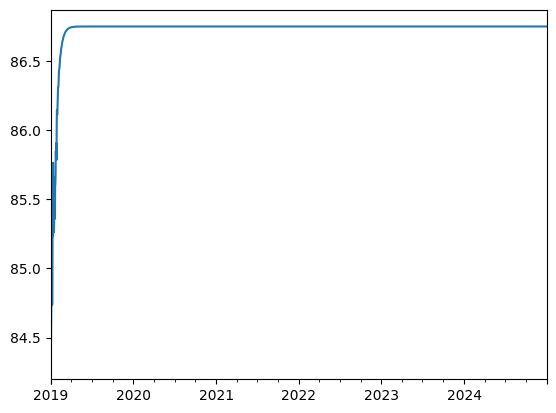

In [38]:
start_dt = '2018-12-31'
end_dt = '2024-12-31'
date_range = pd.date_range(start=start_dt, end=end_dt)
future_preds = model_fit.forecast(steps=len(date_range))
future_preds.index = date_range
pd.DataFrame(future_preds).reset_index().to_csv('forecast.csv', index=False)
future_preds.plot()
